## Урок 3. Кейс 1. Работа с признаками и селекция

### Домашнеее задание

**1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по 1 месяцу.**

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

import os
from random import random
from sklearn.metrics import mean_squared_error
import itertools

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore") # отключает предупреждения

import matplotlib.pyplot as plt

%matplotlib inline

d:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Сделаем месячный ресемплинг

In [3]:
data_m = data.resample('M').mean()

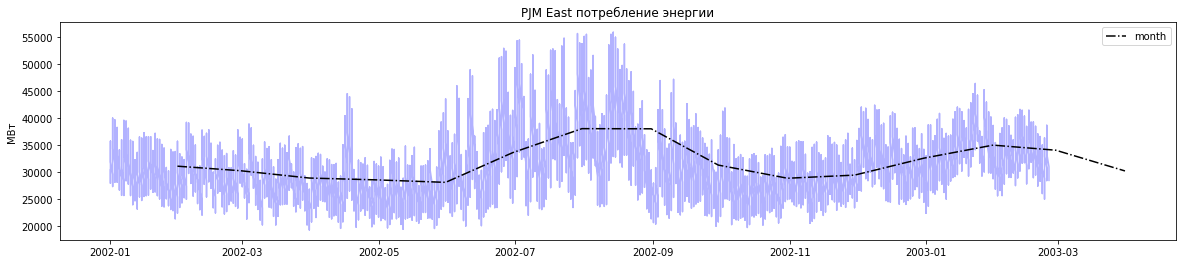

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3)
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month')
plt.title('PJM East потребление энергии')
plt.ylabel('МВт')
plt.legend()
plt.show()

Посмотрим на автокорреляцию месячной модели исходного ряда и его первые разности

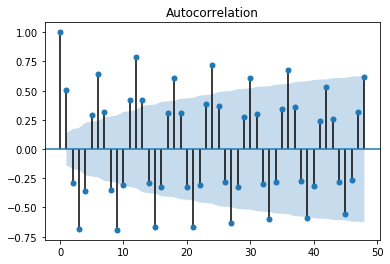

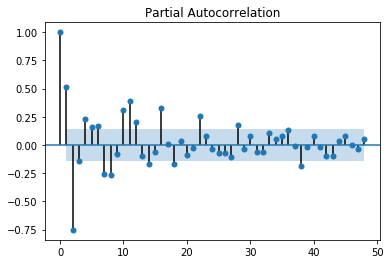

In [5]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=24*2)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=24*2)
plt.show()

**2. Подберите параметры модели SARIMAX для этого ряда.**

Построим SARIMAX

In [6]:
# Определим p, d и q 
q = 2
p = 2
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
# берем месячные данные, тогда сезонность это 12 месяцев
qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,12]

In [7]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [2, 2, 2]    : ps,ds,qs, S= [0, 0, 1, 12]


In [8]:
#для построения модели используем все данные, кроме 6 последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-6],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[2, 2, 2]x[0, 0, 1, 12] - AIC:3221.625491911106


In [9]:
print(results.summary().tables[0], results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  194
Model:             SARIMAX(2, 2, 2)x(0, 0, 1, 12)   Log Likelihood               -1604.813
Date:                            Mon, 20 Apr 2020   AIC                           3221.625
Time:                                    15:27:50   BIC                           3240.682
Sample:                                         0   HQIC                          3229.354
                                            - 194                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

**Анализ результатов по results:**
1. коэффициенты сглаживания ma.L1, ma.L2 , ma.S.L24 являются наиболее важными;
2. значения ar.L1 и ar.L2 имеют большой вес;
3. видимо, удалось подобрать неплохие параметры.

Посмотрим на остатки ряда.

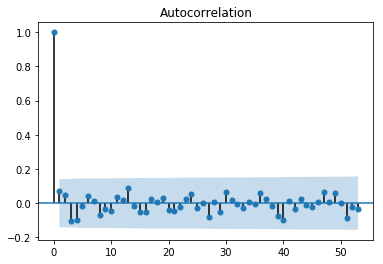

In [10]:
sm.graphics.tsa.plot_acf(results.resid, lags=53)
plt.show()

Остатки незначительны.

Выполним визуализацию plot_diagnostics, где:

- левый верхний график - остатки ряда;
- правый верхний - гистограмма для остатков ряда;
- левый нижний - упорядоченное распределение остатков;
- правый нижний - коррелограмма остатков.

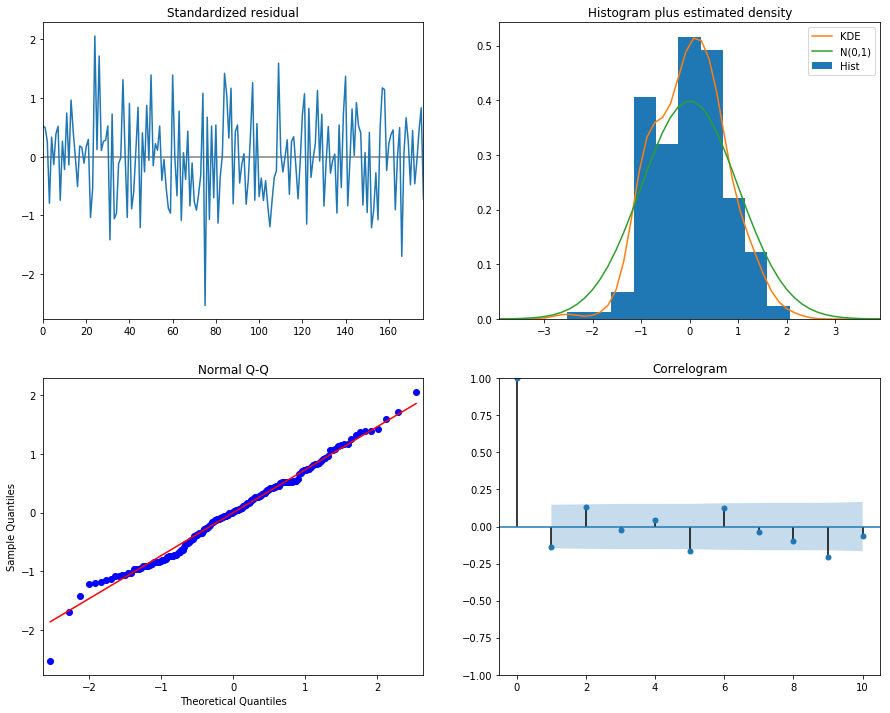

In [11]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Выводы по визуализации:
- распределение близко к нормальному;
- упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N(0, 1);
- остатки не очень похожи на белый шум, т.к. имеют выбросы;
- модель подходит для анализа и прогнозирования данных временных рядов.

Подберем параметры моеди с помощью сеточного поиска

In [12]:
# Определим p, d и q в диапазоне 0-3
p = q = range(0, 3)
d = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = range(0, 3)
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [13]:
data_m['PJME_MW'].values.shape

(200,)

In [14]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-10],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:4463.051035665778
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:4060.74446864495
ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:3759.5420884157747
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:3189.1047595620003
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:2962.900917204554
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2730.1055290308996
ARIMA(0, 0, 0)x(1, 0, 0, 12)3 - AIC:3211.259039000882
ARIMA(0, 0, 0)x(1, 0, 1, 12)3 - AIC:3191.049774025445
ARIMA(0, 0, 0)x(1, 0, 2, 12)3 - AIC:2941.915382582244
ARIMA(0, 0, 0)x(1, 1, 0, 12)3 - AIC:2972.189893609415
ARIMA(0, 0, 0)x(1, 1, 1, 12)3 - AIC:2955.2479807477753
ARIMA(0, 0, 0)x(1, 1, 2, 12)3 - AIC:2722.446862568412
ARIMA(0, 0, 0)x(2, 0, 0, 12)3 - AIC:2973.2943786912683
ARIMA(0, 0, 0)x(2, 0, 1, 12)3 - AIC:2975.494904911483
ARIMA(0, 0, 0)x(2, 0, 2, 12)3 - AIC:2930.0708836169215
ARIMA(0, 0, 0)x(2, 1, 0, 12)3 - AIC:2741.113075753251
ARIMA(0, 0, 0)x(2, 1, 1, 12)3 - AIC:2737.6955220466307
ARIMA(0, 0, 0)x(2, 1, 2, 12)3 - AIC:2722.744746904643
ARIMA(0, 0, 1)x(0, 0, 

ARIMA(0, 2, 2)x(1, 0, 0, 12)3 - AIC:3261.506939467358
ARIMA(0, 2, 2)x(1, 0, 1, 12)3 - AIC:3084.281813664922
ARIMA(0, 2, 2)x(1, 0, 2, 12)3 - AIC:2875.0514494069957
ARIMA(0, 2, 2)x(1, 1, 0, 12)3 - AIC:2984.6498060643517
ARIMA(0, 2, 2)x(1, 1, 1, 12)3 - AIC:2905.699969447054
ARIMA(0, 2, 2)x(1, 1, 2, 12)3 - AIC:2692.3911139460083
ARIMA(0, 2, 2)x(2, 0, 0, 12)3 - AIC:3012.1592285571023
ARIMA(0, 2, 2)x(2, 0, 1, 12)3 - AIC:3005.2496001264426
ARIMA(0, 2, 2)x(2, 0, 2, 12)3 - AIC:2948.3522260008585
ARIMA(0, 2, 2)x(2, 1, 0, 12)3 - AIC:2759.58840994038
ARIMA(0, 2, 2)x(2, 1, 1, 12)3 - AIC:2745.920137077306
ARIMA(0, 2, 2)x(2, 1, 2, 12)3 - AIC:2694.283884676957
ARIMA(1, 0, 0)x(0, 0, 0, 12)3 - AIC:3622.312431853188
ARIMA(1, 0, 0)x(0, 0, 1, 12)3 - AIC:3299.9489026934293
ARIMA(1, 0, 0)x(0, 0, 2, 12)3 - AIC:3089.9934601866125
ARIMA(1, 0, 0)x(0, 1, 0, 12)3 - AIC:3167.3438051514504
ARIMA(1, 0, 0)x(0, 1, 1, 12)3 - AIC:2938.1830221956807
ARIMA(1, 0, 0)x(0, 1, 2, 12)3 - AIC:2700.297738054829
ARIMA(1, 0, 0)x(1, 

ARIMA(1, 2, 1)x(2, 0, 1, 12)3 - AIC:3026.327718491865
ARIMA(1, 2, 1)x(2, 0, 2, 12)3 - AIC:2904.632823838051
ARIMA(1, 2, 1)x(2, 1, 0, 12)3 - AIC:2723.6379967349512
ARIMA(1, 2, 1)x(2, 1, 1, 12)3 - AIC:2733.5451798749564
ARIMA(1, 2, 1)x(2, 1, 2, 12)3 - AIC:2715.90843134798
ARIMA(1, 2, 2)x(0, 0, 0, 12)3 - AIC:3558.3171716822635
ARIMA(1, 2, 2)x(0, 0, 1, 12)3 - AIC:3239.5042821732613
ARIMA(1, 2, 2)x(0, 0, 2, 12)3 - AIC:2999.873381374292
ARIMA(1, 2, 2)x(0, 1, 0, 12)3 - AIC:3184.9250349967224
ARIMA(1, 2, 2)x(0, 1, 1, 12)3 - AIC:2897.3386649354425
ARIMA(1, 2, 2)x(0, 1, 2, 12)3 - AIC:2684.218528958445
ARIMA(1, 2, 2)x(1, 0, 0, 12)3 - AIC:3192.0562142219696
ARIMA(1, 2, 2)x(1, 0, 1, 12)3 - AIC:3146.6012555833677
ARIMA(1, 2, 2)x(1, 0, 2, 12)3 - AIC:2921.67172666364
ARIMA(1, 2, 2)x(1, 1, 0, 12)3 - AIC:2966.9596743466304
ARIMA(1, 2, 2)x(1, 1, 1, 12)3 - AIC:2897.857157464641
ARIMA(1, 2, 2)x(1, 1, 2, 12)3 - AIC:2686.037275447644
ARIMA(1, 2, 2)x(2, 0, 0, 12)3 - AIC:2964.6835685772885
ARIMA(1, 2, 2)x(2, 0

ARIMA(2, 2, 1)x(0, 0, 2, 12)3 - AIC:3017.7023989127415
ARIMA(2, 2, 1)x(0, 1, 0, 12)3 - AIC:3196.9757802322874
ARIMA(2, 2, 1)x(0, 1, 1, 12)3 - AIC:2915.7568411429424
ARIMA(2, 2, 1)x(0, 1, 2, 12)3 - AIC:2670.501346535415
ARIMA(2, 2, 1)x(1, 0, 0, 12)3 - AIC:3172.3535979621165
ARIMA(2, 2, 1)x(1, 0, 1, 12)3 - AIC:3155.4860471612847
ARIMA(2, 2, 1)x(1, 0, 2, 12)3 - AIC:2885.788982323846
ARIMA(2, 2, 1)x(1, 1, 0, 12)3 - AIC:2926.6543255855995
ARIMA(2, 2, 1)x(1, 1, 1, 12)3 - AIC:2903.081862422061
ARIMA(2, 2, 1)x(1, 1, 2, 12)3 - AIC:2672.153546260658
ARIMA(2, 2, 1)x(2, 0, 0, 12)3 - AIC:2911.7222353699344
ARIMA(2, 2, 1)x(2, 0, 1, 12)3 - AIC:2975.0656012173013
ARIMA(2, 2, 1)x(2, 0, 2, 12)3 - AIC:2936.5780632312444
ARIMA(2, 2, 1)x(2, 1, 0, 12)3 - AIC:2694.7509359669193
ARIMA(2, 2, 1)x(2, 1, 1, 12)3 - AIC:2672.4474030807382
ARIMA(2, 2, 1)x(2, 1, 2, 12)3 - AIC:2671.362214581136
ARIMA(2, 2, 2)x(0, 0, 0, 12)3 - AIC:3374.3213203182313
ARIMA(2, 2, 2)x(0, 0, 1, 12)3 - AIC:3151.034049238837
ARIMA(2, 2, 2)x(

Лучшие результаты на месячных данных параметры модели SARIMA(0,1, 2)x(0, 1, 2, 12) - AIC:2636.1243 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

In [15]:
#для построения модели используем все данные, кроме 8-х последних месяцев (это будет тестовый набор)
mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-20],order=[0,1,2],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2472.7524010047496


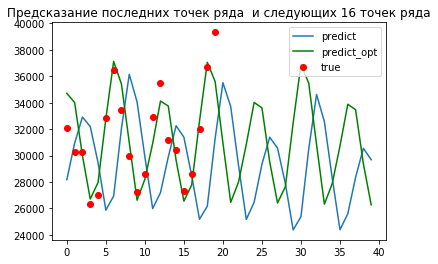

In [16]:
pred_dynamic = results.forecast(40)
pred_dynamic_opt = results_opt.forecast(40)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-20:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 16 точек ряда')
plt.legend()

plt.show()

**3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.**

**Выводы:**
- по графикам очевидно, что новая модель работает лучше;
- по новой модели имеется улучшение предсказанных данных;
- месячная модель более точная в описании характера изменений.

**4. Возьмите вариант 1 или 2**

- Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
- Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )

**Вариант 2**

In [17]:
COVID = pd.read_csv('covid_19_data.csv')
COVID.head(10)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,6,01/22/2020,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,7,01/22/2020,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,8,01/22/2020,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,9,01/22/2020,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,10,01/22/2020,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [18]:
COVID['Data']= pd.to_datetime(COVID['ObservationDate']).dt.date

In [19]:
COVID['Data']= pd.to_datetime(COVID['ObservationDate']).dt.date
COVID = COVID.groupby(['Data','Country/Region'])['Confirmed','Deaths','Recovered'].sum()
COVID.head(20)

Confirmed  Deaths  Recovered
Data       Country/Region                              
2020-01-22 Hong Kong             0.0     0.0        0.0
           Japan                 2.0     0.0        0.0
           Macau                 1.0     0.0        0.0
           Mainland China      547.0    17.0       28.0
           South Korea           1.0     0.0        0.0
           Taiwan                1.0     0.0        0.0
           Thailand              2.0     0.0        0.0
           US                    1.0     0.0        0.0
2020-01-23 Australia             0.0     0.0        0.0
           Brazil                0.0     0.0        0.0
           Colombia              0.0     0.0        0.0
           Hong Kong             2.0     0.0        0.0
           Japan                 1.0     0.0        0.0
           Macau                 2.0     0.0        0.0
           Mainland China      639.0    18.0       30.0
           Malaysia              0.0     0.0        0.0
           Mexico                0.0     0.0        0.0
           Philippines           0.0     0.0        0.0
           Singapore             1.0     0.0        0.0
           South Korea           1.0     0.0        0.0

In [20]:
COV_Russia = COVID.loc[COVID.index.get_level_values( 'Country/Region')=='Russia', ['Confirmed','Deaths','Recovered']]

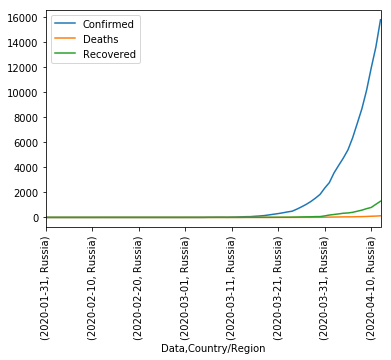

In [21]:
COV_Russia.plot()
plt.xticks(label = COVID.index.get_level_values('Data'), rotation=90)
plt.show()

In [22]:
COV_Russia['Confirmed'].values.shape

(73,)

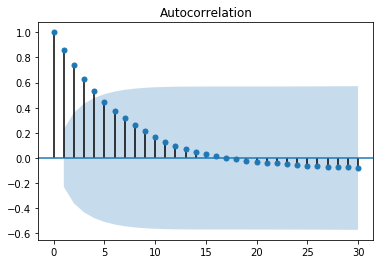

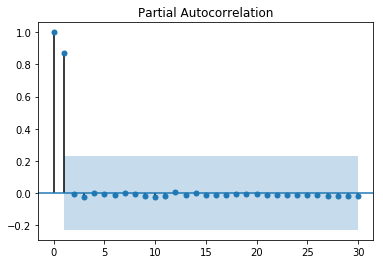

In [23]:
sm.graphics.tsa.plot_acf(COV_Russia['Confirmed'].values, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(COV_Russia['Confirmed'].values, lags=30)
plt.show()

Сезонности не наблюдается.

In [24]:
# Определим p, d и q 
q = 1
p = 1
d = 1
pdq = [p, d, q]


warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(COV_Russia['Confirmed'].values[:-15],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

ARIMA[1, 1, 1] - AIC:432.7853478306666
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -211.393
Date:                Mon, 20 Apr 2020   AIC                            432.785
Time:                        15:41:04   BIC                            442.822
Sample:                             0   HQIC                           436.667
                                 - 58                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    

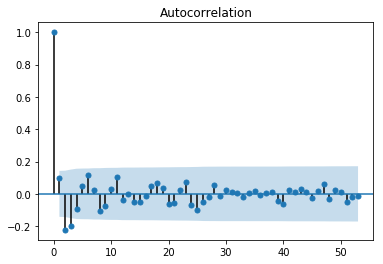

In [25]:
sm.graphics.tsa.plot_acf(results.resid, lags=53)
plt.show()

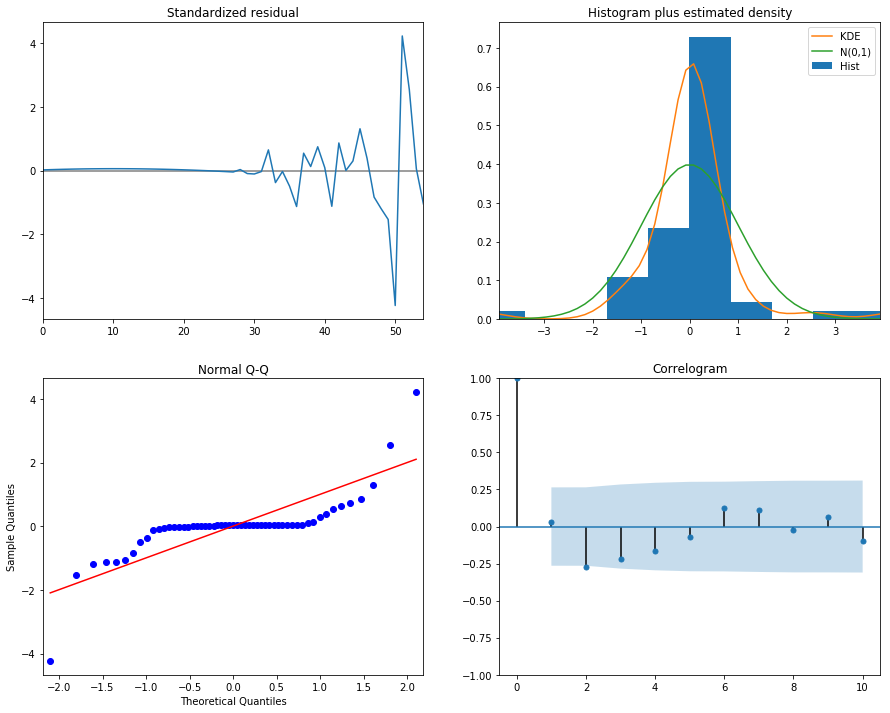

In [26]:
resultsb.plot_diagnostics(figsize=(15, 12))
plt.show()

Диагностика показывает, что остатки модели распределены не по нормальному закону (см. гистограмму).

Estimated density на верхнем-правом графике красная линия KDE находится близко к линии N(0,1).

График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) не следует линейному тренду выборок, взятых из стандартного распределения N(0, 1).

Остатки на верхнем левом графике не похожи на белый шум.

График автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют слабую корреляцию с запаздывающими данными.

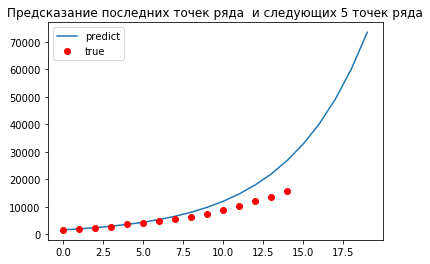

In [27]:
pred_dynamic = resultsb.forecast(20)

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(COV_Russia['Confirmed'].values[-15:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [28]:
d = range(0, 3)
p = range(0, 3)
q = range(0, 7)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(COV_Russia['Confirmed'].values[:-15],
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:772.4097669302926
ARIMA(0, 0, 1)x[0, 0, 0, 0] - AIC:698.5499130170347
ARIMA(0, 0, 2)x[0, 0, 0, 0] - AIC:691.4574967597928
ARIMA(0, 0, 3)x[0, 0, 0, 0] - AIC:625.792216856335
ARIMA(0, 0, 4)x[0, 0, 0, 0] - AIC:668.8969285044847
ARIMA(0, 0, 5)x[0, 0, 0, 0] - AIC:673.3632767093924
ARIMA(0, 0, 6)x[0, 0, 0, 0] - AIC:685.8108433460704
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:575.6170839309029
ARIMA(0, 1, 1)x[0, 0, 0, 0] - AIC:516.5912526930155
ARIMA(0, 1, 2)x[0, 0, 0, 0] - AIC:500.6366299843404
ARIMA(0, 1, 3)x[0, 0, 0, 0] - AIC:496.34401400571244
ARIMA(0, 1, 4)x[0, 0, 0, 0] - AIC:450.10042069045
ARIMA(0, 1, 5)x[0, 0, 0, 0] - AIC:440.84040736987106
ARIMA(0, 1, 6)x[0, 0, 0, 0] - AIC:425.90299520398077
ARIMA(0, 2, 0)x[0, 0, 0, 0] - AIC:458.44101584304764
ARIMA(0, 2, 1)x[0, 0, 0, 0] - AIC:452.06374392555335
ARIMA(0, 2, 2)x[0, 0, 0, 0] - AIC:445.67300612092157
ARIMA(0, 2, 3)x[0, 0, 0, 0] - AIC:438.77860256010854
ARIMA(0, 2, 4)x[0, 0, 0, 0] - AIC:426.93021658107625
ARIMA(0

В результате поиска по сетке определена наилучшая модель ARIMA(0, 2, 6) - AIC:829.3322557276578

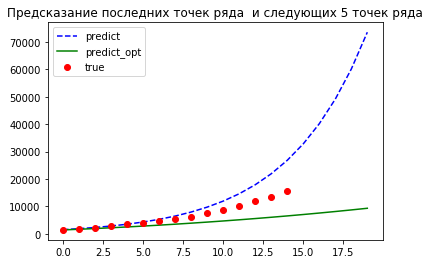

In [29]:
modb_opt = sm.tsa.statespace.SARIMAX(COV_Russia['Confirmed'].values[:-15],
                               order=[0,2,6],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modb_opt.fit()
pred_dynamic = resultsb.forecast(20)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(20) 

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(COV_Russia['Confirmed'].values[-15:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

**5. Оцените результат моделирования**

Улучшенная модель очень хорошо описала действительные значения, но есть тенденция к завышению. 

Однако, это были данные на 14.04. А на данный момент (20.04) мы знаем, что в России был резкий всплеск числа зараженных. Поэтому модель можно считать удовлетворительной.

**6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.**

На мой взгляд, для работы моделей на основе ARIMA важным фактором является полнота данных. Так, например, если мы говорим про COVID-19, то имеющиеся данные никак нельзя назвать ни достаточно полными, ни достаточно точными. Протестированн лишь очень малый процент людей, тестирование ведется неравномерно, есть основания полагать, что госорганы скрывают часть данных.
При полноте данных, техники регрессии на основе ARIMA могли бы вполне сносно справиться с прогнозированием такого развивающегося во времени являния, как инфицирование COVID-19.